### x lines of Python

# Read and write SHP files

This notebook goes with [the blog post of the same name](https://agilescientific.com/blog/2017/8/10/x-lines-of-python-read-and-write-a-shapefile), published on 10 August 2017.

We're going to load a shapefile containing some well data. Then we'll change its CRS, make a new attribute, and save a new shapefile.

We'll lean on `geopandas` for help, but we'll also inspect the file with `fiona`, a lower-level library that `geopandas` uses under the hood.

Install `geopandas` and its dependencies (like `gdal`, `proj`, and `fiona`) with 

    conda install geopandas
    conda install fiona  # I had to do this too to get fiona to work.

In [1]:
import numpy as np
import fiona
import matplotlib.pyplot as plt
import folium
%matplotlib inline

In [2]:
import pprint
with fiona.open('../data/offshore_wells_2011_Geographic_NAD27.shp') as src:
    pprint.pprint(src[0])

{'geometry': {'coordinates': (-59.9170497222, 43.9346961111), 'type': 'Point'},
 'id': '0',
 'properties': OrderedDict([('Well_No_', 1.0),
                            ('D__', 1.0),
                            ('Well_Name', 'Sable Island'),
                            ('Well_Nam_1', 'C-67'),
                            ('Company', 'Mobil et al'),
                            ('Drilling_U', 'Bawden Rig 18'),
                            ('Spud_Date', '1967-06-07'),
                            ('Well_Termi', '1968-01-02'),
                            ('RT_Elevati', 8.2),
                            ('Water_Dept', 3.9),
                            ('Total_Dept', 4604.0),
                            ('Total_De_1', 15106.0),
                            ('Well_Type', 'Exploratory'),
                            ('Well_Symb', 'Plugged dry hole')]),
 'type': 'Feature'}


## Using Geopandas

In [3]:
import geopandas as gpd

Load our data into a GeoDataFrame (gdf):

In [4]:
gdf = gpd.read_file('../data/offshore_wells_2011_Geographic_NAD27.shp')

In [5]:
gdf.head()

,Company,D__,Drilling_U,RT_Elevati,Spud_Date,Total_De_1,Total_Dept,Water_Dept,Well_Nam_1,Well_Name,Well_No_,Well_Symb,Well_Termi,Well_Type,geometry
0,Mobil et al,1.0,Bawden Rig 18,8.2,1967-06-07,15106.0,4604.0,3.9,C-67,Sable Island,1.0,Plugged dry hole,1968-01-02,Exploratory,POINT (-59.9170497222 43.9346961111)
1,Shell,2.0,Sedneth 1,25.9,1969-09-01,13085.0,3988.0,57.9,E-84,Onondaga,2.0,Plugged gas well,1969-11-11,Exploratory,POINT (-60.2214388889 43.721147222222)
2,Shell,3.0,Sedneth 1,25.9,1969-11-16,13516.0,4120.0,82.3,O-25,Oneida,3.0,Plugged dry hole,1970-02-10,Exploratory,POINT (-61.5601366667 43.2492655556)
3,Shell,4.0,Sedneth 1,26.0,1970-02-16,7235.0,2205.0,95.1,N-30,Naskapi,4.0,Plugged dry hole,1970-03-19,Exploratory,POINT (-62.5665408333 43.4963302778)
4,Shell,5.0,Sedco H,31.4,1970-05-03,6975.0,2126.0,117.0,B-93,Mohawk,5.0,Plugged dry hole,1970-05-23,Exploratory,POINT (-64.7315288889 42.7029227778)


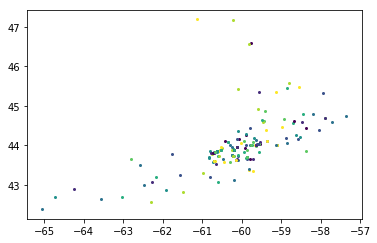

In [6]:
gdf.plot()

Let's look at the first 5 rows of the geometry attribute.

In [7]:
gdf.geometry[:5]

0      POINT (-59.9170497222 43.9346961111)
1    POINT (-60.2214388889 43.721147222222)
2      POINT (-61.5601366667 43.2492655556)
3      POINT (-62.5665408333 43.4963302778)
4      POINT (-64.7315288889 42.7029227778)
Name: geometry, dtype: object

Notice we're in lat, lon:

In [8]:
print(gdf.crs)

{'init': 'epsg:4267'}


Visiting [EPSG 4267](http://spatialreference.org/ref/epsg/4267/) tells us the datum is NAD27.

## Write a new file

Let's cast the SHP to a new CRS: [EPSG 26920](http://spatialreference.org/ref/epsg/26920/):

In [9]:
gdf = gdf.to_crs({'init': 'epsg:26920'})

Now we're in a UTM coordinate system: UTM Zone 20N, with a NAD83 datum:

In [10]:
gdf.geometry[:5]

0    POINT (747510.4372073817 4869250.818941217)
1    POINT (723875.2971043108 4844664.069700127)
2     POINT (616945.850614059 4789511.343230169)
3    POINT (535101.4182156855 4816032.927423127)
4    POINT (358242.7522037996 4729291.710525603)
Name: geometry, dtype: object

Now we'll also add a new attribute with the two-way seismic travel time to the seafloor (in milliseconds).

In [11]:
gdf['seafl_twt'] = 2 * 1000 * gdf.Water_Dept / 1485

In [12]:
gdf.head()

,Company,D__,Drilling_U,RT_Elevati,Spud_Date,Total_De_1,Total_Dept,Water_Dept,Well_Nam_1,Well_Name,Well_No_,Well_Symb,Well_Termi,Well_Type,geometry,seafl_twt
0,Mobil et al,1.0,Bawden Rig 18,8.2,1967-06-07,15106.0,4604.0,3.9,C-67,Sable Island,1.0,Plugged dry hole,1968-01-02,Exploratory,POINT (747510.4372073817 4869250.818941217),5.252525
1,Shell,2.0,Sedneth 1,25.9,1969-09-01,13085.0,3988.0,57.9,E-84,Onondaga,2.0,Plugged gas well,1969-11-11,Exploratory,POINT (723875.2971043108 4844664.069700127),77.979798
2,Shell,3.0,Sedneth 1,25.9,1969-11-16,13516.0,4120.0,82.3,O-25,Oneida,3.0,Plugged dry hole,1970-02-10,Exploratory,POINT (616945.850614059 4789511.343230169),110.841751
3,Shell,4.0,Sedneth 1,26.0,1970-02-16,7235.0,2205.0,95.1,N-30,Naskapi,4.0,Plugged dry hole,1970-03-19,Exploratory,POINT (535101.4182156855 4816032.927423127),128.080808
4,Shell,5.0,Sedco H,31.4,1970-05-03,6975.0,2126.0,117.0,B-93,Mohawk,5.0,Plugged dry hole,1970-05-23,Exploratory,POINT (358242.7522037996 4729291.710525603),157.575758


We can also get a statistical summary of the data frame:

In [13]:
gdf.describe()

,D__,RT_Elevati,Total_De_1,Total_Dept,Water_Dept,Well_No_,seafl_twt
count,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000
mean,237.246377,34.719952,13026.159662,3969.690821,142.545894,104.043478,191.981002
std,127.765494,11.185937,4081.887038,1262.667988,350.268990,59.936723,471.742748
min,0.000000,6.400000,1503.000000,0.000000,0.000000,1.000000,0.000000
25%,129.500000,25.900000,9984.000000,3043.000000,39.500000,52.500000,53.198653
50%,267.000000,31.400000,13202.000000,4024.000000,53.300000,104.000000,71.784512
75%,349.500000,41.500000,15683.000000,4800.500000,82.650000,156.500000,111.313131
max,403.000000,82.000000,21404.000000,6676.000000,2091.500000,207.000000,2816.835017


In [14]:
gdf.to_file('../data/offshore_wells_2011_UTM20_NAD83.shp')

In [15]:
ls ../data/*.shp

../data/offshore_wells_2011_Geographic_NAD27.shp*
../data/offshore_wells_2011_UTM20_NAD83.shp


## Extra: GeoJSON

GeoJSON is a standard format for encoding geospatial data. Think of it as a more web-friendly shapefile. (It's friendly because it's all contained in a single file, and the file is in JSON format, which JavaScript can process natively and other languages can easily consume).

In [16]:
# Must be geographic coords, so casting to WGS84.
gdf = gdf.to_crs({'init': 'epsg:4326'})

with open('../data/offshore_wells.geojson', 'w') as f:
    f.write(gdf.to_json())

You can easily load GeoJSON into [QGIS](http://www.qgis.org/en/site/) for your usual GIS workflow. 

It's pretty cool how GeoJSON files show up [in GitHub](https://github.com/agile-geoscience/xlines/blob/master/data/offshore_wells.geojson).

## Extra: Maps with folium

You can get slippy maps right in Jupyter Notebook with `folium`. Install it with:

    conda install folium

In [17]:
import folium

# Must be geographic coords, so casting to WGS84.
gdf = gdf.to_crs({'init': 'epsg:4326'})

# Make the map, add the features via GeoJSON.
mymap = folium.Map(location=[45, -62], zoom_start=7)
features = folium.features.GeoJson(gdf.to_json())
mymap.add_child(features)

mymap

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2016</p>
</div>